# **Predicting house prices**

# **1. Dataset description** 

Number of Attributes: 4 textual attributes in addition to the visual attributes that can be extracted from the images.

Attribute Information:
- Number of bedrooms
- Number of bathrooms
- Area (i.e., square footage)
- Zip code

For more info and credits visit:\
https://github.com/omarsayed7/House-price-estimation-from-visual-and-textual-features

<a id="Libraries"></a> <br>
# **2. Libraries and data** 

In [1]:
import warnings 
from collections import Counter 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/file/d/1Ithoy81UTGXRMdAtENRTSrs97QFJmqko/view?usp=sharing' 

id = link.split("/")[-2]
filename= 'HousesInfo.txt'
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(filename)

In [5]:
header = ['bedrooms', 'bathrooms', 'area', 'zipcode', 'price']
df = pd.read_csv(filename, header=None, delimiter=' ', names=header)

<a id="Known"></a> <br>
# **3. First look at the data** 

In [6]:
#Searching for null values,data types and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   535 non-null    int64  
 1   bathrooms  535 non-null    float64
 2   area       535 non-null    int64  
 3   zipcode    535 non-null    int64  
 4   price      535 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.0 KB


In [7]:
#Looking at unique values
df.nunique()

bedrooms       9
bathrooms     14
area         435
zipcode       49
price        369
dtype: int64

In [8]:
#Looking at a data sample
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0000,4053,85255,869500
1,4,3.0000,3343,36372,865200
2,3,4.0000,3923,85266,889000
3,5,5.0000,4022,85262,910000
4,3,4.0000,4116,85266,971226


# **4. Feature Engineering** <a id="Feature Engineering"></a> <br>

## Null treatement

In [9]:
# Null treatement

## Treatement of Categorical variables

In [10]:
df['bedrooms'].value_counts()

3     182
4     145
2     123
5      61
6      13
1       5
7       3
8       2
10      1
Name: bedrooms, dtype: int64

In [11]:
df['bathrooms'].value_counts()

2.0000    217
3.0000     95
2.5000     66
4.0000     43
3.5000     37
1.0000     24
5.0000     16
1.5000     14
4.5000     14
6.0000      3
5.5000      2
6.5000      2
3.2500      1
7.0000      1
Name: bathrooms, dtype: int64

In [12]:
# round bathrooms to full integer values
#df['bathrooms'] = df['bathrooms'].round(0)

In [13]:
# Put all zipcodes with less than 4 frequency in Other category
df_zip = df['zipcode'].value_counts().rename_axis('zipcode').reset_index(name='counts')
df_zip['zip_code'] = df_zip['zipcode']
df_zip['zip_code'][df_zip['counts']<4] = 'Other'

# Merge the new zip_code category in the initial dataframe
df = pd.merge(df, df_zip[['zipcode','zip_code']], on=['zipcode'], how='left')
df['zip_code'].value_counts()

92276    100
93510     60
93446     54
92880     49
94501     41
Other     40
91901     32
92677     26
94531     22
85255     12
96019     12
93111     11
92021     11
81524     11
85266     11
95220     10
92802      9
85262      9
62234      7
62214      4
98021      4
Name: zip_code, dtype: int64

In [14]:
y = df['price']   # Separate target variable
df.drop(['price', 'zipcode'], axis = 1, inplace=True)  # delete unecessary columns

In [15]:
categ = list(df.select_dtypes(['object']).columns | df.select_dtypes(['category']).columns)
print(categ)

['zip_code']


In [16]:
# One hot encoder for Categorical Variables
print('Data frame shape before Categorical Values encoding: ',df.shape)
df = pd.get_dummies(data=df, columns=categ)
print('Data frame shape after Categorical Values encoding: ',df.shape)


Data frame shape before Categorical Values encoding:  (535, 4)
Data frame shape after Categorical Values encoding:  (535, 24)


In [17]:
df.head()

,bedrooms,bathrooms,area,zip_code_62214,zip_code_62234,zip_code_81524,zip_code_85255,zip_code_85262,zip_code_85266,zip_code_91901,zip_code_92021,zip_code_92276,zip_code_92677,zip_code_92802,zip_code_92880,zip_code_93111,zip_code_93446,zip_code_93510,zip_code_94501,zip_code_94531,zip_code_95220,zip_code_96019,zip_code_98021,zip_code_Other
0,4,4.0000,4053,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,3.0000,3343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,4.0000,3923,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,5.0000,4022,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,4.0000,4116,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Looking at the correlation of the data

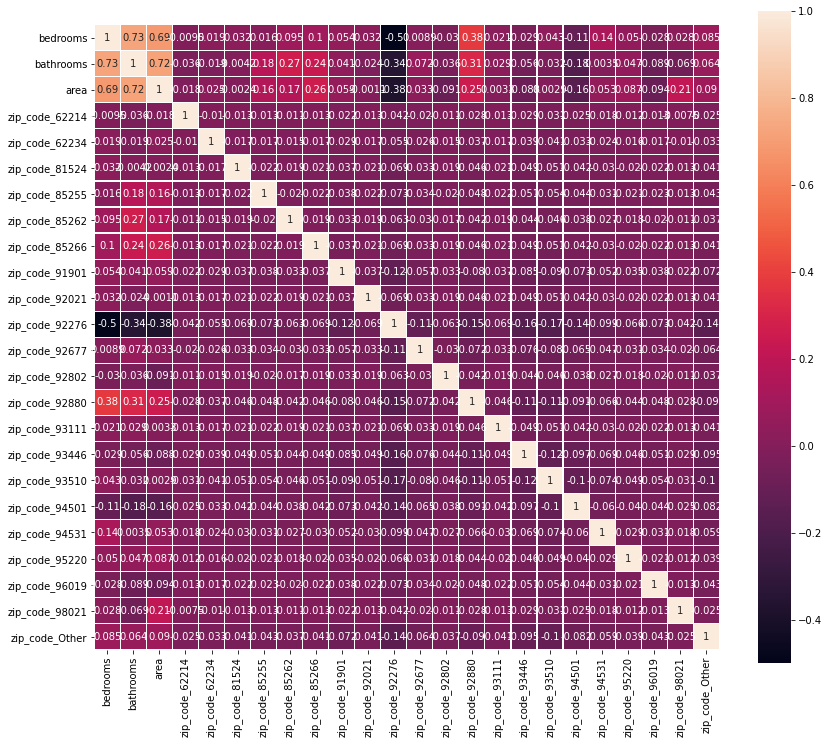

In [18]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [19]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [20]:
corr_features = correlation(df, 0.9)
print(corr_features)

for column in corr_features:
  df.drop(column, axis=1,inplace=True)

set()


# **5. Train/Test split and Scaling** <a id="Train/Test split and Scaling"></a> <br>


## Import libraries

In [21]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

## Prepare and split Dataset into Train and Test

In [22]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

## Scale input for distance-based models (Linear Regression, Support Vector Regressor)

In [23]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [24]:
# normalize target
max_price = y_train.max()
y_train = y_train/ max_price
y_test = y_test / max_price

# **6. Implement models** <a id="Implement models"></a> <br>

### Define model evaluation function


In [25]:
def model_eval(model,X_test,y_test):
  y_pred = model.predict(X_test)

  y_pred_orig = y_pred * max_price
  y_test_orig = y_test * max_price

  print("Test mean           : {:.2f}".format(np.mean(y_test_orig)))
  print("Price Std (baseline): {:.2f}".format(np.std(y_test_orig)))
  print("Test RMSE           : {:.2f}".format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))))
  print("Test MAE            : {:.2f}".format(mean_absolute_error(y_test_orig,y_pred_orig)))
  print("R² score            : {:.4f}".format(r2_score(y_test_orig,y_pred_orig)))

### Linear Regression

In [26]:
# import libraries
from sklearn.linear_model import LinearRegression

In [27]:
# train the model
model_LR = LinearRegression()
model_LR.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [28]:
# predict on test data
y_pred = model_LR.predict(X_test_scaled)

In [29]:
# evaluate the model results
model_eval(model_LR,X_test_scaled,y_test)

Test mean           : 552423.59
Price Std (baseline): 372103.68
Test RMSE           : 248490.30
Test MAE            : 177065.15
R² score            : 0.5540


In [30]:
# Print intercept and coefficients
print ('Model intercept: '+str(model_LR.intercept_))

# model coefficients
pd.DataFrame(model_LR.coef_, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

# For every one-unit increase in [X variable], the [y variable] increases 
# by [coefficient] when all other variables are held constant.

Model intercept: 0.029124717365984654


,coef
area,0.2146
bathrooms,0.1583
zip_code_93111,0.1448
zip_code_94501,0.0660
zip_code_92677,0.0599
zip_code_95220,0.0447
zip_code_85255,0.0393
zip_code_92802,0.0135
zip_code_93510,0.0127
zip_code_91901,0.0093


### Support Vector Reggresor

In [31]:
# import libraries
from sklearn.svm import SVR

In [32]:
# train the model
model_SVR = SVR()
model_SVR.fit(X_train_scaled, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [33]:
# predict on test data
y_pred = model_SVR.predict(X_test_scaled)

In [34]:
model_eval(model_SVR,X_test_scaled,y_test)

Test mean           : 552423.59
Price Std (baseline): 372103.68
Test RMSE           : 430038.91
Test MAE            : 391935.65
R² score            : -0.3356


### Decision Tree Regressor

In [35]:
# import libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [36]:
# train the model
model_DT = DecisionTreeRegressor(max_depth=4, random_state=42)
model_DT.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [37]:
# predict on test data
y_pred = model_DT.predict(X_test)

In [38]:
model_eval(model_DT,X_test,y_test)

Test mean           : 552423.59
Price Std (baseline): 372103.68
Test RMSE           : 299235.22
Test MAE            : 211751.66
R² score            : 0.3533


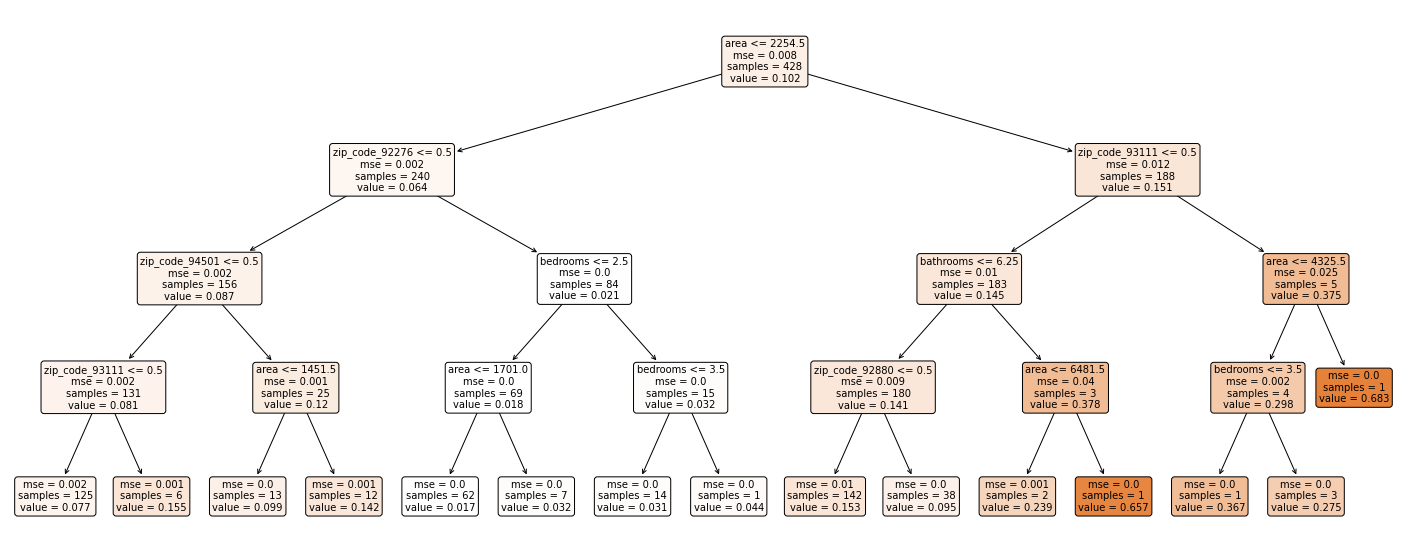

In [39]:
# plot tree
plt.figure(figsize=(25,10))  # set plot size (denoted in inches)
tree.plot_tree(model_DT, fontsize=10,
               feature_names=X_train.columns, class_names=['good','bad'],
               filled=True, rounded=True)
plt.show()

In [40]:
from sklearn.tree import export_text
r = export_text(model_DT, feature_names=list(X_train.columns))
print(r)

|--- area <= 2254.50
|   |--- zip_code_92276 <= 0.50
|   |   |--- zip_code_94501 <= 0.50
|   |   |   |--- zip_code_93111 <= 0.50
|   |   |   |   |--- value: [0.08]
|   |   |   |--- zip_code_93111 >  0.50
|   |   |   |   |--- value: [0.15]
|   |   |--- zip_code_94501 >  0.50
|   |   |   |--- area <= 1451.50
|   |   |   |   |--- value: [0.10]
|   |   |   |--- area >  1451.50
|   |   |   |   |--- value: [0.14]
|   |--- zip_code_92276 >  0.50
|   |   |--- bedrooms <= 2.50
|   |   |   |--- area <= 1701.00
|   |   |   |   |--- value: [0.02]
|   |   |   |--- area >  1701.00
|   |   |   |   |--- value: [0.03]
|   |   |--- bedrooms >  2.50
|   |   |   |--- bedrooms <= 3.50
|   |   |   |   |--- value: [0.03]
|   |   |   |--- bedrooms >  3.50
|   |   |   |   |--- value: [0.04]
|--- area >  2254.50
|   |--- zip_code_93111 <= 0.50
|   |   |--- bathrooms <= 6.25
|   |   |   |--- zip_code_92880 <= 0.50
|   |   |   |   |--- value: [0.15]
|   |   |   |--- zip_code_92880 >  0.50
|   |   |   |   |--- val

Further reading:\
https://scikit-learn.org/stable/modules/tree.html


### Ensemble methods: Random Forrest Regressor

In [41]:
# import libraries
from sklearn.ensemble import RandomForestRegressor

In [42]:
# train the model
model_RF = RandomForestRegressor(random_state=42)
model_RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [43]:
# predict on test data
y_pred = model_RF.predict(X_test)

In [44]:
model_eval(model_RF,X_test,y_test)

Test mean           : 552423.59
Price Std (baseline): 372103.68
Test RMSE           : 222024.05
Test MAE            : 146012.81
R² score            : 0.6440


### Ensemble methods: XGBoost Regressor

In [45]:
# import libraries
from xgboost import XGBRegressor

In [46]:
# train the model
model_XGB = XGBRegressor(objective ='reg:squarederror', random_state=42)
model_XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

https://xgboost.readthedocs.io/en/latest/parameter.html

In [47]:
# predict on test data
y_pred = model_XGB.predict(X_test)

In [48]:
model_eval(model_XGB,X_test,y_test)

Test mean           : 552423.59
Price Std (baseline): 372103.68
Test RMSE           : 211241.10
Test MAE            : 140431.17
R² score            : 0.6777


# **7. Model Selection** <a id="Model Selection"></a> <br>

In [49]:
def run_models(X_train, X_train_scaled, y_train, n_splits):
  # prepare models
  models = []
  model_names = ['LR','SVR','DT','RF','XGB']
  models.append(('Linear Regression       ', model_LR))
  models.append(('Support Vector Regressor', model_SVR))
  models.append(('Decision Tree Regressor ', model_DT))
  models.append(('Random Forest Regressor ', model_RF))
  models.append(('XGBoost Regressor       ', model_XGB))
  
  # evaluate each model in turn
  results = []
  names = []
  scoring='r2'
  
  print('Model                    | R2')
  for name, model in models:
    kfold = KFold(n_splits=n_splits)
    cv_results = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s | %.4f " % (name, cv_results.mean() )
    print(msg)
  print('')
  
  # boxplot model comparison
  fig = plt.figure(figsize=(8,4))
  fig.suptitle('Models Performance Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(model_names)
  plt.show()

Model                    | R2
Linear Regression        | 0.5487 
Support Vector Regressor | -0.5369 
Decision Tree Regressor  | -0.0065 
Random Forest Regressor  | 0.5251 
XGBoost Regressor        | 0.5712 



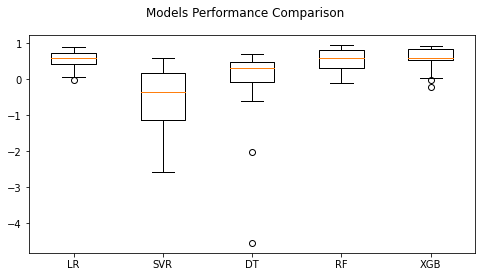

In [50]:
run_models(X_train, X_train_scaled, y_train,25)

# **8. Hyperparameter Tuning** <a id="Hyperparameter Tuning"></a> <br>

In [51]:
regressor = model_XGB
params = {'max_depth':[4,5,6],
          'n_estimators':[300,400,500,600],
          'learning_rate':[0.03,0.05,0.07,0.09]}
#          'min_child_weight':[3,5,10],
#          'gamma':[0.0, 0.1, 0.2],
#          'subsample':[i/100.0 for i in range(75,90,5)],
#          'colsample_bytree':[i/100.0 for i in range(75,90,5)]}

grid_search = GridSearchCV(regressor, param_grid=params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=4,verbose=3)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   41.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=42, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'learning_rate': [0.03, 0.05, 0.07, 0.09],
                         'max_depth': [4, 5, 6],
           

In [52]:
print('Best score     :',grid_search.best_score_)
print('Best parameters:',grid_search.best_params_)
regressor = grid_search.best_estimator_

Best score     : -0.06495848323323608
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}


In [53]:
# Predict results on test data
y_pred = regressor.predict(X_test_scaled)

In [54]:
model_eval(regressor,X_test_scaled,y_test)

Test mean           : 552423.59
Price Std (baseline): 372103.68
Test RMSE           : 190044.16
Test MAE            : 120038.01
R² score            : 0.7392


# **9. Model Explainability** <a id="Model Explainability"></a> <br>

In [55]:
!pip install shap

     |████████████████████████████████| 358kB 5.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=e96270db13a6c027c82953ebad8cd2b0019f40ac532cb85e44e6a01faa946b42
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [56]:
import shap
explainer = shap.Explainer(regressor)
shap_values = explainer(X_test)

### Global Interpretability

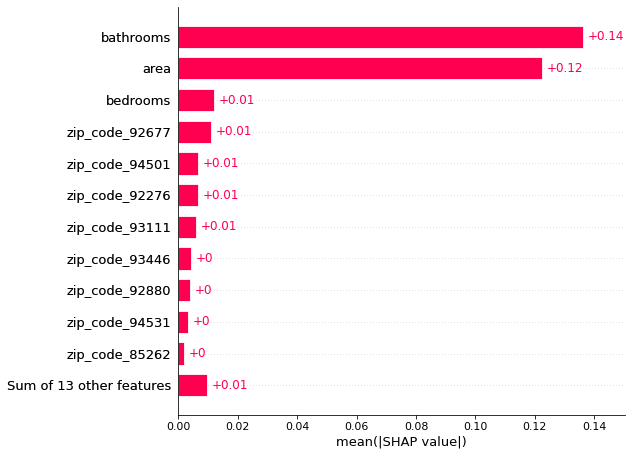

In [57]:
# Feature importance - bar plot
shap.plots.bar(shap_values, max_display=12) # default is max_display=12

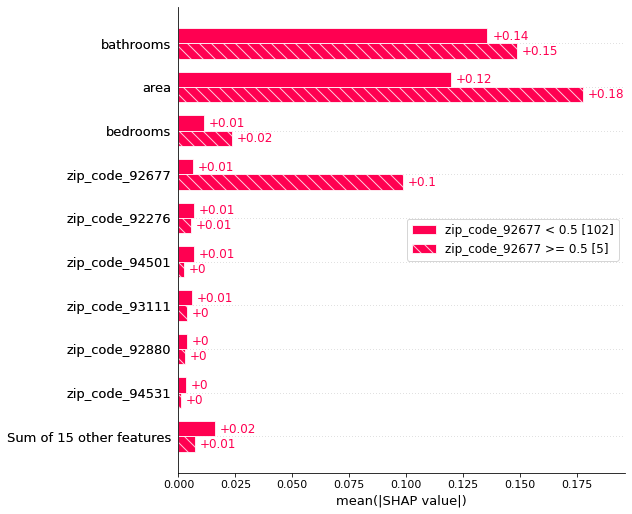

In [58]:
# Feature importance - cohort plot 
#(explanation.cohorts(N) can create N cohorts that optimally separate the SHAP values 
# of the instances using a sklearn DecisionTreeRegressor)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

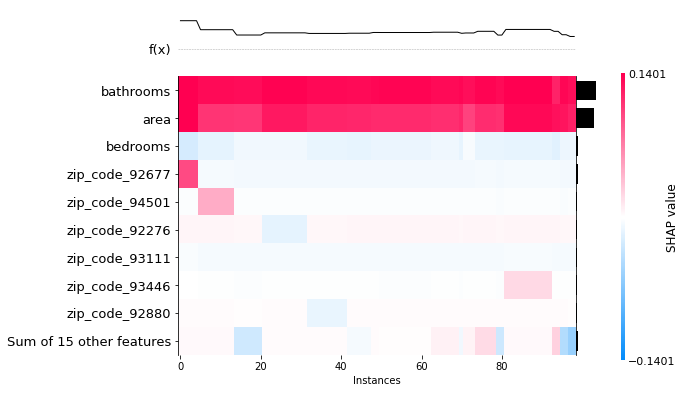

In [59]:
# Heatmap - first 100 examples
shap.plots.heatmap(shap_values[1:100])

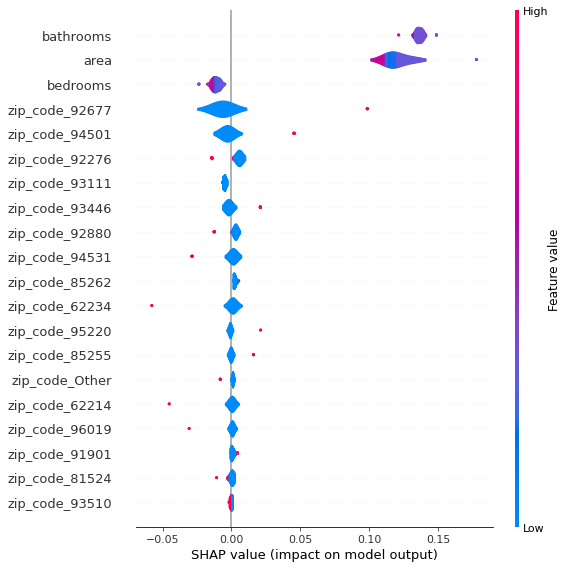

In [60]:
# Feature importance and contribution - violin plot
shap.summary_plot(explainer.shap_values(X_test), X_test, plot_type="violin")

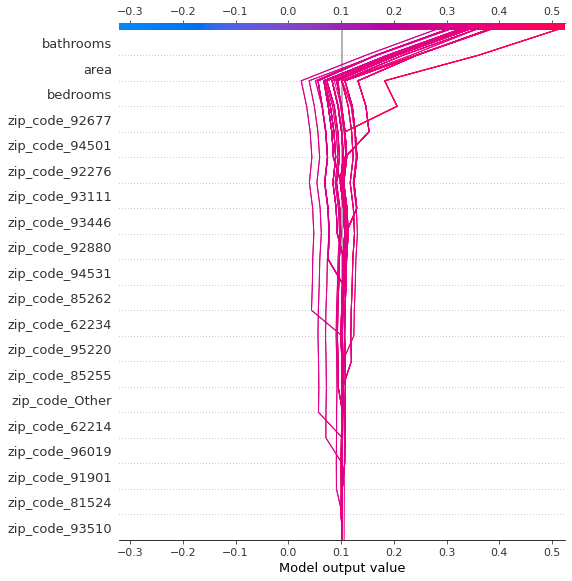

In [61]:
# Shap decision plot
r = shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test), X_test, 
                       return_objects=True, ignore_warnings=True)

### Local Interpretability

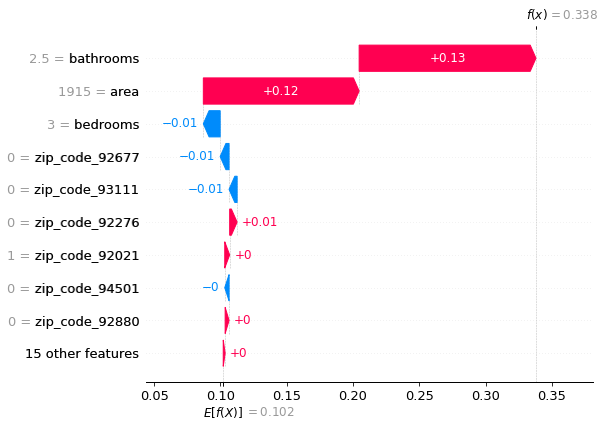

In [62]:
# Individual waterfall plot
id=0
shap.plots.waterfall(shap_values[id]) # For the first observation

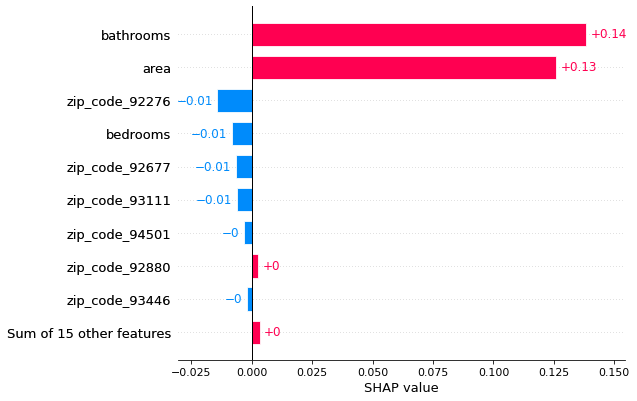

In [63]:
# Individual bar plot
id = 5
shap.plots.bar(shap_values[id]) # For the first observation

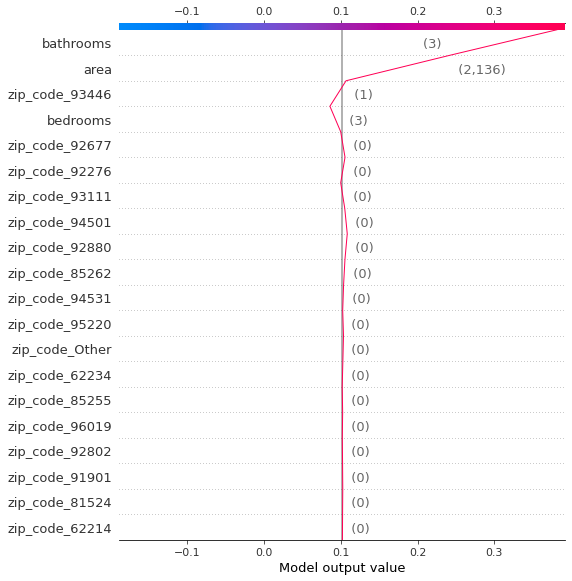

In [64]:
# Individual decision plot
id = 15
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[id,:], X_test.iloc[id,:])

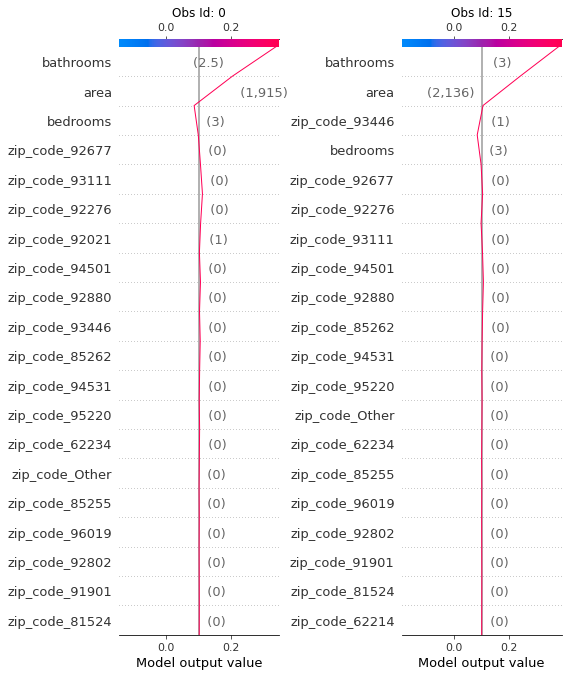

In [65]:
# Individual decision plot comparison for two observations
id1=0
id2=15

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[id1,:], 
                   X_test.iloc[id1,:], show=False)
ax1.title.set_text('Obs Id: '+str(id1))
ax2 = fig.add_subplot(122)
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[id2,:], 
                   X_test.iloc[id2,:], show=False)
ax2.title.set_text('Obs Id: '+str(id2))
plt.tight_layout()
plt.show()

In [66]:
# Individual force plot
shap.initjs()
id=3
shap.force_plot(explainer.expected_value, explainer.shap_values(X_test)[id,:], X_test.iloc[id,:])

In [67]:
# Interactive general force plot
shap.initjs()
shap.force_plot(explainer.expected_value, explainer.shap_values(X_test), X_test)

In [68]:
# Dependence plots
X_test.columns

Index(['bedrooms', 'bathrooms', 'area', 'zip_code_62214', 'zip_code_62234',
       'zip_code_81524', 'zip_code_85255', 'zip_code_85262', 'zip_code_85266',
       'zip_code_91901', 'zip_code_92021', 'zip_code_92276', 'zip_code_92677',
       'zip_code_92802', 'zip_code_92880', 'zip_code_93111', 'zip_code_93446',
       'zip_code_93510', 'zip_code_94501', 'zip_code_94531', 'zip_code_95220',
       'zip_code_96019', 'zip_code_98021', 'zip_code_Other'],
      dtype='object')

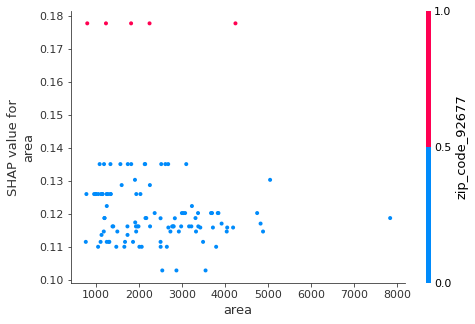

In [69]:
# Dependence plots based on a feature with automatic interaction feature
feature = "area"
shap.dependence_plot(feature, explainer.shap_values(X_test), X_test)

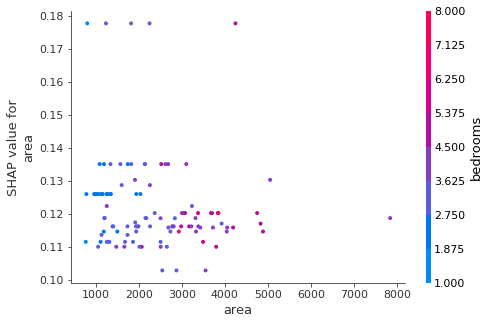

In [70]:
# Dependence plots based on a feature with defined interaction feature
feature = "area"
interaction_feature = "bedrooms"
shap.dependence_plot(feature, explainer.shap_values(X_test), X_test, interaction_index=interaction_feature)

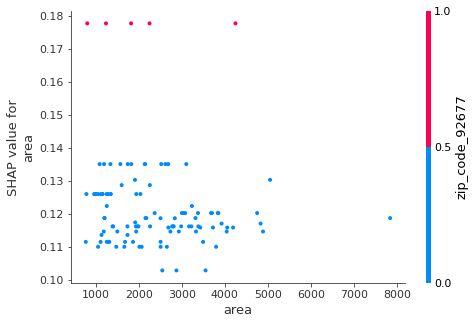

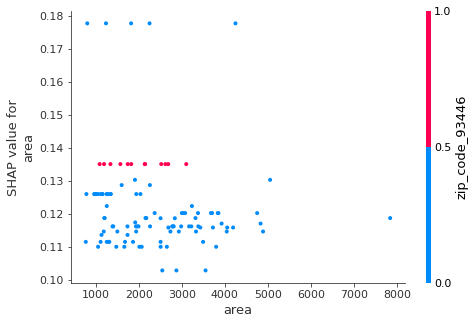

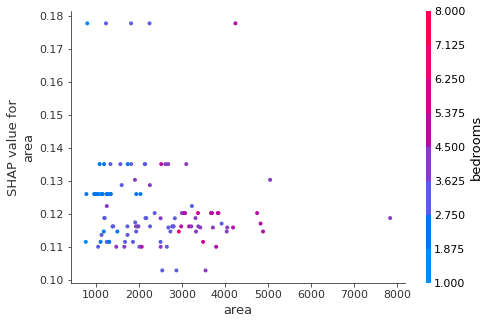

In [71]:
# use approximate_interactions to guess top three possible interactions
feature = "area"
inds = shap.approximate_interactions(feature, explainer.shap_values(X_test), X_test)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot(feature, explainer.shap_values(X_test), X_test, interaction_index=inds[i])